# Classification Algorithms Benchmarks
In this notebook we are comparing the results of some Classification Algorithms we tried.
Those Algorithms were:
* Logistic Regression
* KNN
* SVM
* Neural Network

The evaluation process will be to compare the f_1 macro scores and f_1 micro scores to see which algorithm performs better.

But first we will start by exploring the data.

## Data Exploration

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
#Importing the cleaned data set
data = pd.read_csv('Datasets/cleaned_train.csv', index_col=0)
data.head()

,month,day,country,title,text,hazard-category,product-category,hazard,product
year,,,,,,,,,
1994,1,7,us,"name: gerhard's napa valley sausage, product:...","name: gerhard's napa valley sausage, product:...",biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1994,3,10,us,"name: wimmer's meat products, product: wiene...","name: wimmer's meat products, product: wiene...",biological,"meat, egg and dairy products",listeria spp,sausage
1994,3,28,us,"name: willow foods inc, product: ham, sliced...","name: willow foods inc, product: ham, sliced...",biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
1994,4,3,us,"name: oscar mayer foods, product: beef frank...","name: oscar mayer foods, product: beef frank...",foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
1994,7,1,us,"name: tyson foods, product: chicken breast c...","name: tyson foods, product: chicken breast c...",foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast


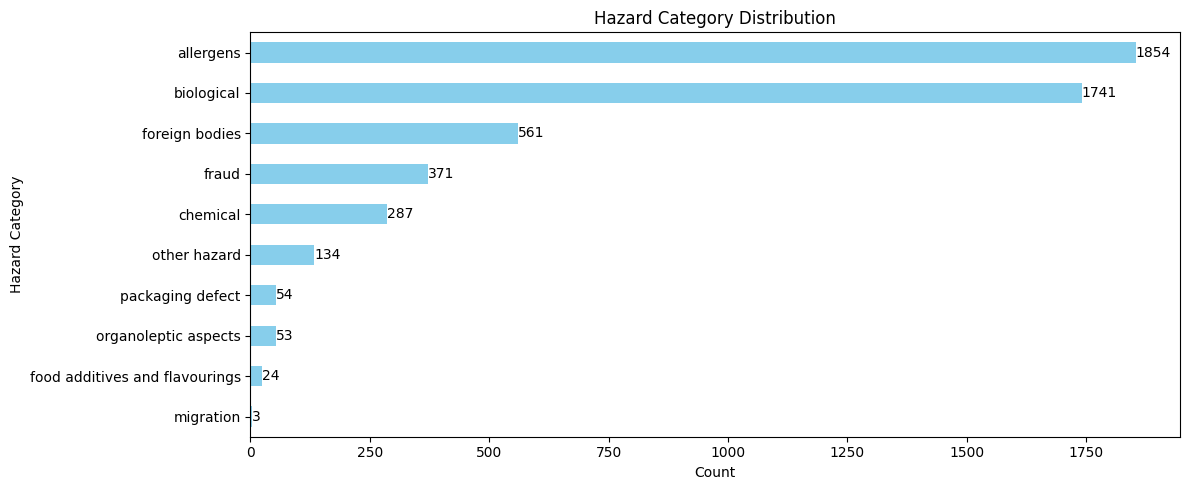

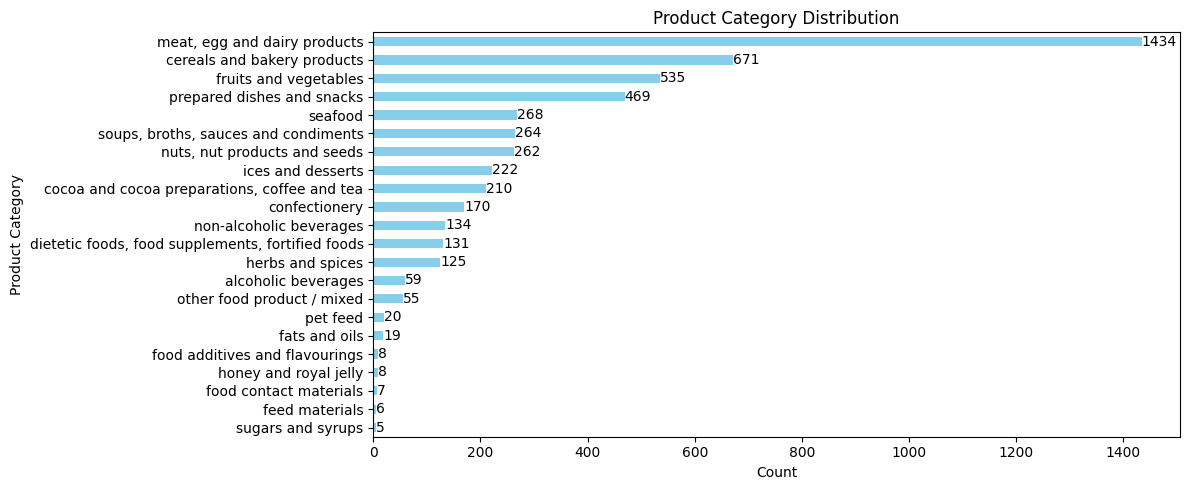

In [63]:
def plot_horizontal_bar(data, column, figsize=(12, 5)):
    # Count occurrences of each category and sort in ascending order
    counts = data[column].value_counts().sort_values(ascending=True)
    
    # Create the horizontal bar plot
    plt.figure(figsize=figsize)
    counts.plot(kind='barh', color='skyblue')
    
    # Add count labels to the right of each bar
    for index, value in enumerate(counts):
        plt.text(value, index, str(value), va='center')  # Add value labels
    
    # Add titles and labels
    plt.title(f"{column.replace('-', ' ').title()} Distribution")
    plt.xlabel("Count")
    plt.ylabel(column.replace('-', ' ').title())
    plt.tight_layout()
    plt.show()

# List of columns to plot
columns_to_plot = ['hazard-category', 'product-category']

# Generate plots for each column
for col in columns_to_plot:
    plot_horizontal_bar(data, col)

From the above bar plots we can see that the classes for Hazard-Category and Product-Category are highly imbalanced.

Next we are going to see how balanced the Hazard and the Product columns are.

In [64]:
for column in ['hazard','product']:
    num_unique_label = data[column].nunique()
    print(f"Number of distinct {column}: {num_unique_label}\n" )

    # Display the top N products by count
    top_n = 8
    top_label = data[column].value_counts().head(top_n)
    print(f"Top {top_n} most frequent {column}s:")
    print(top_label,"\n")

Number of distinct hazard: 128

Top 8 most frequent hazards:
hazard
listeria monocytogenes                            665
salmonella                                        621
milk and products thereof                         588
escherichia coli                                  237
peanuts and products thereof                      211
eggs and products thereof                         208
cereals containing gluten and products thereof    207
plastic fragment                                  206
Name: count, dtype: int64 

Number of distinct product: 1022

Top 8 most frequent products:
product
ice cream                    185
chicken based products       138
cakes                         93
ready to eat - cook meals     79
cookies                       78
cheese                        74
salads                        55
ground beef                   52
Name: count, dtype: int64 



We can already see that there is a class imbalancing from the above stats but we can visualise it better below in a "sampled" bar plot where we have chosen only some of the classes due to the great amount of unique classes.

In the bar plots below we are only showing the top 10, the 10 median and the bottom 10 classes based on the value counts.

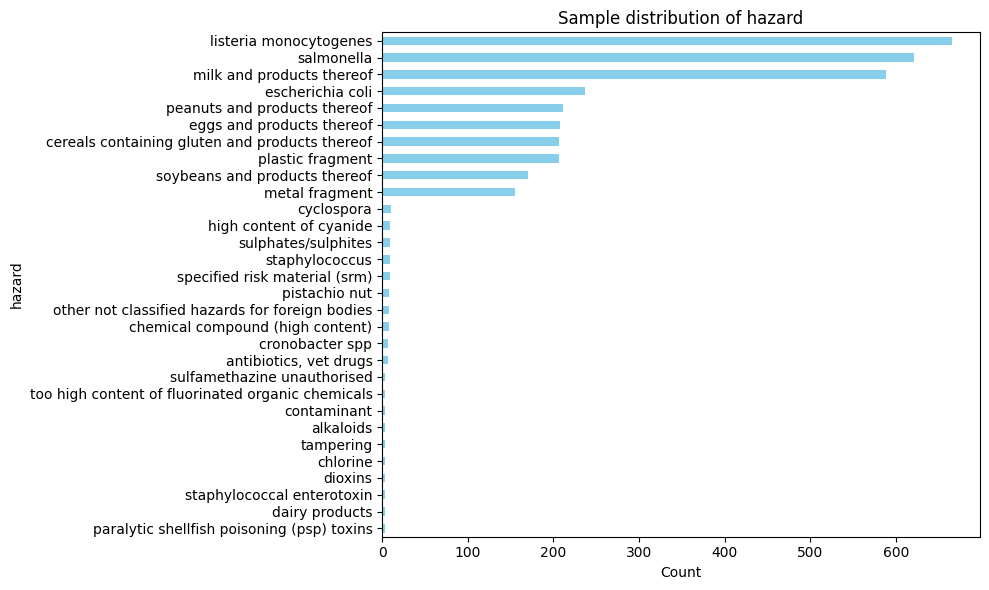

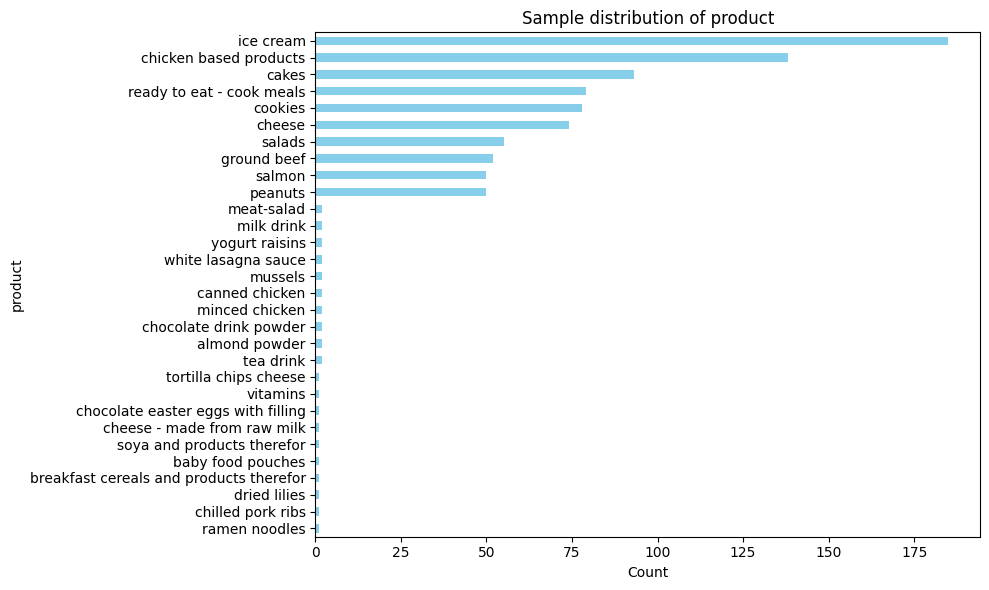

In [65]:
def plot_sample(data, column, top_n=10, figsize=(10, 6)):
    # Count the occurrences
    value_counts = data[column].value_counts()
    
    # Extract top-N and bottom-N
    top_classes = value_counts.head(top_n)
    middle_start = (len(value_counts) - top_n) // 2
    middle_end = middle_start + top_n
    middle_classes = value_counts.iloc[middle_start:middle_end]
    bottom_classes = value_counts.tail(top_n)
    
    # Combine top and bottom into a single DataFrame
    combined_classes = pd.concat([top_classes,middle_classes ,bottom_classes])
    
    # Plot
    plt.figure(figsize=figsize)
    combined_classes.sort_values().plot(kind='barh', color='skyblue')
    plt.title(f"Sample distribution of {column}")
    plt.xlabel("Count")
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()

# Visualize for 'Hazard' column
plot_sample(data, 'hazard')

# Visualize for 'Product' column
plot_sample(data, 'product')

## Evaluating the Basic Models
We will train our models both on the title and the text column to see which one achieves better results.

In [66]:
#Loading the packages
from sklearn.model_selection import cross_validate,KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
#Loading the models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm


For the evaluation task instead of using just a data set split into train set and a test set i have chosen to use a k-fold cross validation.\
In my case i am going to use a 3-fold cross validation due to time limitations.\
This approach is implemented below

In [67]:
#Initializing the dictionary where the results of our models will be stored.
model_results = {}

Defining the k-fold cross validation function that prints out the f1 macro and f1 micro scores of the model trained on the right column.

In [68]:
# Derining the k-fold function that takes the pipeline, the name of the model, the train column 'title' or 'text' and the number of splits
def train_kfold(clf, name, column, n_splits=3):
    print(f"The {name} {column} model has the scorings for:")
    f1_macro = []
    f1_micro = []
    for label in ('hazard-category', 'product-category', 'hazard', 'product'):
        print(label.upper())
        
        # K-fold cross-validation: Here we use cross_validate for more detailed results
        cv_results = cross_validate(clf, data[column], data[label], cv=n_splits, 
                                    scoring = ['f1_macro', 'f1_micro'], return_train_score=False)

        # Print results
        print(f'  Macro F1 score (mean): {cv_results["test_f1_macro"].mean():.2f}')
        print(f'  Macro F1 score (std): {cv_results["test_f1_macro"].std():.2f}')
        print(f'  Micro F1 score (mean): {cv_results["test_f1_micro"].mean():.2f}')
        print(f'  Micro F1 score (std): {cv_results["test_f1_micro"].std():.2f}')
        f1_macro.append(cv_results["test_f1_macro"].mean())
        f1_micro.append(cv_results["test_f1_micro"].mean())

    #Storing the results for the specific model
    model_results[name+' '+column] = {'f_1 macro':f1_macro , 'f_1 micro':f1_micro}      

Lets run and evaluate our first model the Logistic Regression using the title column for the training.

In [69]:
# Defining the pipeline using the Tdidf Vectorizer
title_clf_lr = Pipeline([
    ('vect', TfidfVectorizer(strip_accents='unicode', analyzer='char', ngram_range=(2,5), max_df=0.5, min_df=5)),
    ('clf', LogisticRegression(max_iter=1000)),
])

# Train using 3-fold cross-validation
train_kfold(title_clf_lr, 'Logistic Regression', 'title')

The Logistic Regression title model has the scorings for:
HAZARD-CATEGORY
  Macro F1 score (mean): 0.38
  Macro F1 score (std): 0.06
  Micro F1 score (mean): 0.78
  Micro F1 score (std): 0.06
PRODUCT-CATEGORY
  Macro F1 score (mean): 0.30
  Macro F1 score (std): 0.01
  Micro F1 score (mean): 0.60
  Micro F1 score (std): 0.01
HAZARD
  Macro F1 score (mean): 0.10
  Macro F1 score (std): 0.01
  Micro F1 score (mean): 0.49
  Micro F1 score (std): 0.05
PRODUCT


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


  Macro F1 score (mean): 0.04
  Macro F1 score (std): 0.00
  Micro F1 score (mean): 0.25
  Micro F1 score (std): 0.01


We have printed out the means and the standard errors of the f1 scores for each classification task.

We can see that the results of the Logistic Regression model with the specific vectorizer aren't that "high".

Next we are going to train a KNN model with the same vectorizer as before.

In [70]:
title_clf_knn = Pipeline([
    ('vect', TfidfVectorizer(strip_accents='unicode', analyzer='char', ngram_range=(2,5), max_df=0.5, min_df=5)),
     ('clf', KNeighborsClassifier()),
    ])


train_kfold(title_clf_knn, 'KNN', 'title')

The KNN title model has the scorings for:
HAZARD-CATEGORY
  Macro F1 score (mean): 0.49
  Macro F1 score (std): 0.09
  Micro F1 score (mean): 0.75
  Micro F1 score (std): 0.05
PRODUCT-CATEGORY
  Macro F1 score (mean): 0.30
  Macro F1 score (std): 0.02
  Micro F1 score (mean): 0.50
  Micro F1 score (std): 0.03
HAZARD
  Macro F1 score (mean): 0.20
  Macro F1 score (std): 0.02
  Micro F1 score (mean): 0.44
  Micro F1 score (std): 0.05
PRODUCT


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


  Macro F1 score (mean): 0.10
  Macro F1 score (std): 0.01
  Micro F1 score (mean): 0.23
  Micro F1 score (std): 0.02


The KNN model seems to have a little better results than the Logistic Regression model.

The next model we are going to try is an SVM model.

In [71]:
title_clf_svm = Pipeline([
    ('vect', TfidfVectorizer(strip_accents='unicode', analyzer='char', ngram_range=(2,5), max_df=0.5, min_df=5)),
     ('clf', svm.SVC(kernel='linear', C=10, class_weight='balanced')),
    ])

train_kfold(title_clf_svm, 'SVM', 'title')

The SVM title model has the scorings for:
HAZARD-CATEGORY
  Macro F1 score (mean): 0.59
  Macro F1 score (std): 0.14
  Micro F1 score (mean): 0.78
  Micro F1 score (std): 0.07
PRODUCT-CATEGORY
  Macro F1 score (mean): 0.49
  Macro F1 score (std): 0.03
  Micro F1 score (mean): 0.64
  Micro F1 score (std): 0.01
HAZARD
  Macro F1 score (mean): 0.31
  Macro F1 score (std): 0.07
  Micro F1 score (mean): 0.55
  Micro F1 score (std): 0.08
PRODUCT


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


  Macro F1 score (mean): 0.19
  Macro F1 score (std): 0.03
  Micro F1 score (mean): 0.37
  Micro F1 score (std): 0.03


The SVM model seems to have achieved the best results out of the 3 title trained model.

Now we will follow the same approach with the three models mentioned above, using the text column. However, this time, we will utilize a different vectorizer with the parameter 'word' instead of 'char', due to the greater length of the text compared to before.

In [72]:
#Logistic Regression Text Model
text_clf_lr = Pipeline([
    ('vect', TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,2), max_df=0.5, min_df=5)),
     ('clf', LogisticRegression(max_iter=1000)),
    ])


train_kfold(text_clf_lr, 'Logistic Regression', 'text')

The Logistic Regression text model has the scorings for:
HAZARD-CATEGORY
  Macro F1 score (mean): 0.41
  Macro F1 score (std): 0.05
  Micro F1 score (mean): 0.83
  Micro F1 score (std): 0.01
PRODUCT-CATEGORY
  Macro F1 score (mean): 0.21
  Macro F1 score (std): 0.01
  Micro F1 score (mean): 0.48
  Micro F1 score (std): 0.02
HAZARD
  Macro F1 score (mean): 0.11
  Macro F1 score (std): 0.01
  Micro F1 score (mean): 0.62
  Micro F1 score (std): 0.01
PRODUCT


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


  Macro F1 score (mean): 0.02
  Macro F1 score (std): 0.00
  Micro F1 score (mean): 0.17
  Micro F1 score (std): 0.00


In [73]:
#KNN Text Model
text_clf_knn = Pipeline([
    ('vect', TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,2), max_df=0.5, min_df=5)),
     ('clf', KNeighborsClassifier()),
    ])


train_kfold(text_clf_knn, 'KNN', 'text')

The KNN text model has the scorings for:
HAZARD-CATEGORY
  Macro F1 score (mean): 0.38
  Macro F1 score (std): 0.04
  Micro F1 score (mean): 0.72
  Micro F1 score (std): 0.02
PRODUCT-CATEGORY
  Macro F1 score (mean): 0.23
  Macro F1 score (std): 0.02
  Micro F1 score (mean): 0.38
  Micro F1 score (std): 0.05
HAZARD
  Macro F1 score (mean): 0.18
  Macro F1 score (std): 0.02
  Micro F1 score (mean): 0.46
  Micro F1 score (std): 0.03
PRODUCT


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


  Macro F1 score (mean): 0.05
  Macro F1 score (std): 0.01
  Micro F1 score (mean): 0.14
  Micro F1 score (std): 0.02


In [74]:
#SVM Text Model
text_clf_svm = Pipeline([
    ('vect', TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,2), max_df=0.5, min_df=5)),
     ('clf', svm.SVC(kernel='linear', C=10, class_weight='balanced')),
    ])
# The parameter 'balanced' takes into consideration the imbalance of our data

train_kfold(text_clf_svm, 'SVM', 'text')

The SVM text model has the scorings for:
HAZARD-CATEGORY
  Macro F1 score (mean): 0.50
  Macro F1 score (std): 0.05
  Micro F1 score (mean): 0.84
  Micro F1 score (std): 0.03
PRODUCT-CATEGORY
  Macro F1 score (mean): 0.39
  Macro F1 score (std): 0.01
  Micro F1 score (mean): 0.53
  Micro F1 score (std): 0.05
HAZARD
  Macro F1 score (mean): 0.32
  Macro F1 score (std): 0.04
  Micro F1 score (mean): 0.64
  Micro F1 score (std): 0.04
PRODUCT


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


  Macro F1 score (mean): 0.12
  Macro F1 score (std): 0.02
  Micro F1 score (mean): 0.25
  Micro F1 score (std): 0.03


In [75]:
model_results

{'Logistic Regression title': {'f_1 macro': [0.38291203103620414,
   0.30239667358394784,
   0.09559521598999952,
   0.04125704137141837],
  'f_1 micro': [0.7792207792207791,
   0.595434868162141,
   0.49449035812672176,
   0.2473435655253837]},
 'KNN title': {'f_1 macro': [0.4880681612587121,
   0.2993119192826296,
   0.20297583386052223,
   0.09734859663246483],
  'f_1 micro': [0.7453758362849272,
   0.500590318772137,
   0.43722943722943725,
   0.2349468713105077]},
 'SVM title': {'f_1 macro': [0.5858509331917863,
   0.4934514232652825,
   0.30556717503777736,
   0.18837924267060577],
  'f_1 micro': [0.7835497835497836,
   0.6442345533254624,
   0.5476190476190476,
   0.36875245966155057]},
 'Logistic Regression text': {'f_1 macro': [0.40532656974597225,
   0.20875474718601636,
   0.11327172801537581,
   0.02415453143087336],
  'f_1 micro': [0.8305785123966943,
   0.4840613931523022,
   0.6153089334907517,
   0.16883116883116886]},
 'KNN text': {'f_1 macro': [0.3825459419547947,
   

Now that we have the models results we are going to calculate the average f1_macro and f1_micro scores over the 4 classification tasks to see which model performs better.

In [76]:
#Initialize lists to hold average scores
average_macro = []
average_micro = []

#Iterating the model results dict to calculate the average scores
for model, scores in model_results.items():
    #Calculating the averages
    avg_macro = sum(scores['f_1 macro']) / len(scores['f_1 macro'])
    avg_micro = sum(scores['f_1 micro']) / len(scores['f_1 micro'])
    
    average_macro.append(avg_macro)
    average_micro.append(avg_micro)

# Create the DataFrame with the average scores
df_avg_scores = pd.DataFrame({
    'Model': model_results.keys(),
    'f_1 macro': average_macro,
    'f_1 micro': average_micro
})

# Set the 'Model' column as the index for the DataFrame
df_avg_scores.set_index('Model', inplace=True)

# Display the resulting DataFrame
print(df_avg_scores)

#Saving the model results in a CSV to be accessible easily without rerunning the models
df_avg_scores.to_csv('Scores/Basic Models f1 scores.csv')

                           f_1 macro  f_1 micro
Model                                          
Logistic Regression title   0.205540   0.529122
KNN title                   0.271926   0.479536
SVM title                   0.393312   0.586039
Logistic Regression text    0.187877   0.524695
KNN text                    0.211647   0.427883
SVM text                    0.333585   0.567001


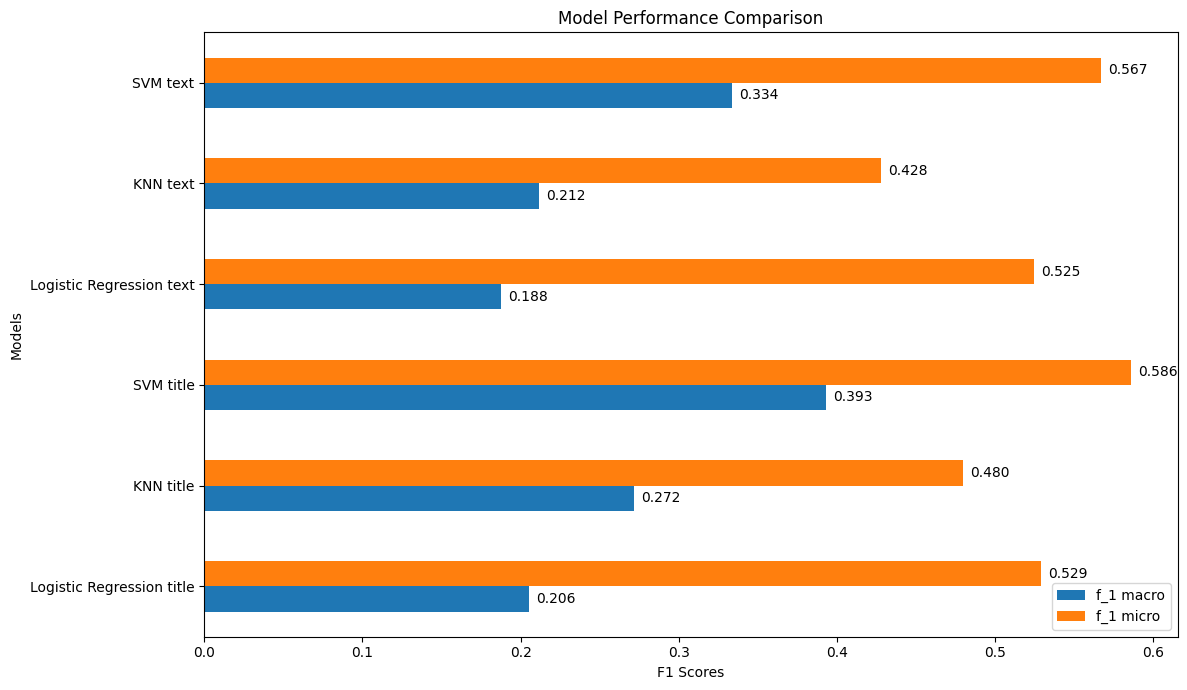

In [77]:
# Create the plot
plt.figure(figsize=(12, 7))
ax = df_avg_scores.plot.barh(ax=plt.gca())

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=5)

plt.title('Model Performance Comparison')
plt.xlabel('F1 Scores')
plt.ylabel('Models')
plt.tight_layout()
plt.show()

We can see that the f1 micro score is signifacantlly greater than the f1 macro score.\
This is expected because the classes are highly imbalanced and the f1 micro score takes it into consideration while the f1 score doesn't.

### Choosing the best basic model
The Scores of the Hazard Detection competition are calculated using the f1 score.\
So we are going to choose the algorithm with the better f1 score.\
This algorithm is the SVM text model.\
However we will try both SVM text and SVM title models.\
Thus we are going to try to achieve the best results from it.


First we are going to define the function that gives the scores of the competition

In [78]:
def compute_score(hazards_true, products_true, hazards_pred, products_pred):
  # compute f1 for hazards:
  f1_hazards = f1_score(
    hazards_true,
    hazards_pred,
    average='macro'
  )

  # compute f1 for products:
  f1_products = f1_score(
    products_true[hazards_pred == hazards_true],
    products_pred[hazards_pred == hazards_true],
    average='macro'
  )

  return (f1_hazards + f1_products) / 2.

Below we are defining a training function that uses a k-fold split to our data and calculates the average scores for each subtask.

In [79]:
svm_results = {}

In [80]:
def model_train(clf,column):
    #Lists to save the subtask results
    SB1 = []
    SB2 = []
    #Spliting the data using 3 folds
    kf = KFold(n_splits=3, shuffle=True, random_state=2024)

    #Looping for each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
        print(f'Fold {fold+1}:')
        #Spliting the data into train and validation set
        trainset, valset = data.iloc[train_idx].copy(), data.iloc[val_idx].copy()

        for label in ('hazard-category', 'product-category', 'hazard', 'product'):
            print(label.upper())

            clf.fit(trainset[column], trainset[label])

            #Predicting on the validation set
            valset['predictions-' + label] = clf.predict(valset[column])
        
        #Get the scores for each subtask    
        SB1.append(compute_score(valset['hazard-category'], valset['product-category'], valset['predictions-hazard-category'], valset['predictions-product-category']))
        SB2.append(compute_score(valset['hazard'], valset['product'], valset['predictions-hazard'], valset['predictions-product']))
    
    svm_results['SVM '+column] = {'SB1':SB1,'SB2':SB2}
    
    print(f"Average Score Sub-Task 1 for the {column} trained SVM: {np.mean(SB1):.3f}")
    print(f"Average Score Sub-Task 2 for the {column} trained SVM: {np.mean(SB2):.3f}")

In [81]:
model_train(title_clf_svm,'title')

Fold 1:
HAZARD-CATEGORY
PRODUCT-CATEGORY
HAZARD
PRODUCT
Fold 2:
HAZARD-CATEGORY
PRODUCT-CATEGORY
HAZARD
PRODUCT
Fold 3:
HAZARD-CATEGORY
PRODUCT-CATEGORY
HAZARD
PRODUCT
Average Score Sub-Task 1 for the title trained SVM: 0.601
Average Score Sub-Task 2 for the title trained SVM: 0.280


In [82]:
model_train(text_clf_svm,'text')

Fold 1:
HAZARD-CATEGORY
PRODUCT-CATEGORY
HAZARD
PRODUCT
Fold 2:
HAZARD-CATEGORY
PRODUCT-CATEGORY
HAZARD
PRODUCT
Fold 3:
HAZARD-CATEGORY
PRODUCT-CATEGORY
HAZARD
PRODUCT
Average Score Sub-Task 1 for the text trained SVM: 0.564
Average Score Sub-Task 2 for the text trained SVM: 0.260


In [83]:
svm_results

{'SVM title': {'SB1': [0.5514820729497627,
   0.6158179257838514,
   0.6354180207125983],
  'SB2': [0.2863781067711208, 0.2802940487551734, 0.2733108423688093]},
 'SVM text': {'SB1': [0.5761117950612391,
   0.5577100559992241,
   0.5572451997915491],
  'SB2': [0.26756801544207703, 0.25970958697698326, 0.25383299850976576]}}

In [84]:
average_SB1 = []
average_SB2 = []

#Iterating the model results dict to calculate the average scores
for model, scores in svm_results.items():
    #Calculating the averages
    avg_SB1 = np.mean(scores['SB1'])
    avg_SB2 = np.mean(scores['SB2'])
    
    average_SB1.append(avg_SB1)
    average_SB2.append(avg_SB2)

# Create the DataFrame with the average scores
SVM_subtask_scores = pd.DataFrame({
    'Model': svm_results.keys(),
    'SB1':average_SB1,
    'SB2':average_SB2
})

# Set the 'Model' column as the index for the DataFrame
SVM_subtask_scores.set_index('Model', inplace=True)

#Saving the model results in a CSV to be accessible easily without rerunning the models
SVM_subtask_scores.to_csv('Scores/SVM Subtask Scores.csv')

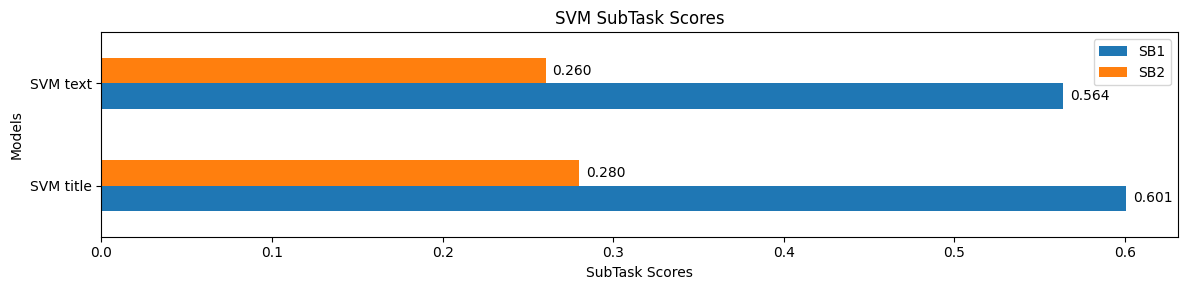

In [85]:
# Create the plot
plt.figure(figsize=(12, 3))
ax = SVM_subtask_scores[['SB1','SB2']].plot.barh(ax=plt.gca())

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=5)

plt.title('SVM SubTask Scores')
plt.xlabel('SubTask Scores')
plt.ylabel('Models')
plt.tight_layout()
plt.show()

## Defining a Neural Network
In the sequence we are going to define a neural network to compare it with the SVM model.\
The code the neural network was found online and it was adapted to the specific problem.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

We will start by defining the Neural Network

In [7]:
# Neural Network Definition
class TextClassifierNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(TextClassifierNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [8]:
# Initializing a dictionary to save the Neural Network results
nn_results ={}

Next we are going to define a training function that uses a k-fold cross validation to evaluate the results of the Neural Network.\
The training function gets as inputs the vectorizer and the train column.

In [9]:
def training_with_cv(vectorizer, column, n_splits=3):
    # Initialize K-Fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Initialize result storage
    cv_results = {label: {'macro_f1': [], 'micro_f1': []} for label in ('hazard-category', 'product-category', 'hazard', 'product')}

    # Dictionaries to save the Subtask scores
    SB1 = []
    SB2 = []
    
    # Prepare data
    vectorizer.fit(data[column])
    X = vectorizer.transform(data[column]).toarray()
    
    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    hidden_dim = 128
    batch_size = 32
    epochs = 10
    learning_rate = 1e-3
    
    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}/{n_splits}")
        
        # Split data into training and validation sets
        X_train, X_val = X[train_idx], X[val_idx]
        trainset, valset = data.iloc[train_idx].copy(), data.iloc[val_idx].copy()
        initial_val = data.iloc[val_idx].copy()

        # Create label encoders for each target column
        label_encoders = {}

        # Create label encoders and evaluate each label independently
        for label in ('hazard-category', 'product-category', 'hazard', 'product'):
            print(f"  Training for label: {label}")
            
            # Encode labels
            le = LabelEncoder()
            le.fit_transform(data[label])
            trainset[label] = le.transform(trainset[label])
            valset[label] = le.transform(valset[label])
            label_encoders[label] = le

            
            # Prepare targets
            y_train = trainset[label].values
            y_val = valset[label].values
            num_classes = len(le.classes_)
            
            # Convert to tensors
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train, dtype=torch.long)
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
            y_val_tensor = torch.tensor(y_val, dtype=torch.long)
            
            # Initialize the model
            model = TextClassifierNN(input_dim=X_train.shape[1], hidden_dim=hidden_dim, num_classes=num_classes)
            model.to(device)
            
            # Define optimizer and loss
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            criterion = nn.CrossEntropyLoss()
            
            # Training loop
            model.train()
            for epoch in range(epochs):
                for i in range(0, len(X_train_tensor), batch_size):
                    batch_X = X_train_tensor[i:i + batch_size].to(device)
                    batch_y = y_train_tensor[i:i + batch_size].to(device)
                    
                    # Forward pass
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    
                    # Backward pass and optimization
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            
            # Evaluation on validation set
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_tensor.to(device))
                val_predictions = torch.argmax(val_outputs, axis=1).cpu().numpy()
            
            #Saving 
            initial_val['predictions-'+label] = label_encoders[label].inverse_transform(val_predictions)
            
            # Metrics for this fold
            macro_f1 = f1_score(y_val, val_predictions, zero_division=0, average="macro")
            micro_f1 = f1_score(y_val, val_predictions, zero_division=0, average="micro")

            # Store fold metrics
            cv_results[label]['macro_f1'].append(macro_f1)
            cv_results[label]['micro_f1'].append(micro_f1)
            print(f"    Fold {fold + 1} - macro F1: {macro_f1:.2f}, micro F1: {micro_f1:.2f}")
    
        # Calculating the scores for each subtask for this fold
        SB1.append(compute_score(initial_val['hazard-category'], initial_val['product-category'], initial_val['predictions-hazard-category'], initial_val['predictions-product-category']))
        SB2.append(compute_score(initial_val['hazard'], initial_val['product'], initial_val['predictions-hazard'], initial_val['predictions-product']))


    # Aggregate results across folds
    f1_macro = []
    f1_micro = []
    for label in cv_results:
        print(f'The {column} trained Neural Network  has the scorings for:')
        print(label.upper())
        print(f"  Macro F1 score (mean): {np.mean(cv_results[label]['macro_f1']):.2f}")
        print(f"  Macro F1 score (std): {np.std(cv_results[label]['macro_f1']):.2f}")
        print(f"  Micro F1 score (mean): {np.mean(cv_results[label]['micro_f1']):.2f}")
        print(f"  Micro F1 score (std): {np.std(cv_results[label]['micro_f1']):.2f}")
        f1_macro.append(np.mean(cv_results[label]['macro_f1']))
        f1_micro.append(np.mean(cv_results[label]['micro_f1']))
    
    nn_results['Neural Network '+column] = {'f_1 macro':f1_macro , 'f_1 micro':f1_micro, 'SB1':SB1, 'SB2':SB2}

Next we are defining the TF-IDF vectorizers, we will use the same vectorizers with the Basic Models.

In [10]:
# TF-IDF Vectorizer
title_tfidf_vect = TfidfVectorizer(strip_accents='unicode', analyzer='char', ngram_range=(3, 6), max_df=0.5, min_df=3)
text_tfidf_vect = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,2), max_df=0.5, min_df=5)

In [ ]:
#Training the Neural Network with the title column
training_with_cv(title_tfidf_vect, 'title')

Fold 1/3
  Training for label: hazard-category
    Fold 1 - macro F1: 0.56, micro F1: 0.83
  Training for label: product-category
    Fold 1 - macro F1: 0.53, micro F1: 0.72
  Training for label: hazard
    Fold 1 - macro F1: 0.29, micro F1: 0.60
  Training for label: product
    Fold 1 - macro F1: 0.18, micro F1: 0.39
Fold 2/3
  Training for label: hazard-category
    Fold 2 - macro F1: 0.57, micro F1: 0.84
  Training for label: product-category
    Fold 2 - macro F1: 0.61, micro F1: 0.72
  Training for label: hazard
    Fold 2 - macro F1: 0.34, micro F1: 0.61
  Training for label: product
    Fold 2 - macro F1: 0.19, micro F1: 0.40
Fold 3/3
  Training for label: hazard-category
    Fold 3 - macro F1: 0.62, micro F1: 0.85
  Training for label: product-category
    Fold 3 - macro F1: 0.51, micro F1: 0.72
  Training for label: hazard
    Fold 3 - macro F1: 0.32, micro F1: 0.64
  Training for label: product
    Fold 3 - macro F1: 0.19, micro F1: 0.39
The title trained Neural Network  has

In [ ]:
#Training the Neural Network with the text column
training_with_cv(text_tfidf_vect, 'text')

Fold 1/3
  Training for label: hazard-category
    Fold 1 - macro F1: 0.58, micro F1: 0.89
  Training for label: product-category
    Fold 1 - macro F1: 0.45, micro F1: 0.65
  Training for label: hazard
    Fold 1 - macro F1: 0.29, micro F1: 0.72
  Training for label: product
    Fold 1 - macro F1: 0.10, micro F1: 0.28
Fold 2/3
  Training for label: hazard-category
    Fold 2 - macro F1: 0.68, micro F1: 0.91
  Training for label: product-category
    Fold 2 - macro F1: 0.48, micro F1: 0.67
  Training for label: hazard
    Fold 2 - macro F1: 0.31, micro F1: 0.72
  Training for label: product
    Fold 2 - macro F1: 0.09, micro F1: 0.28
Fold 3/3
  Training for label: hazard-category
    Fold 3 - macro F1: 0.61, micro F1: 0.90
  Training for label: product-category
    Fold 3 - macro F1: 0.48, micro F1: 0.66
  Training for label: hazard
    Fold 3 - macro F1: 0.30, micro F1: 0.73
  Training for label: product
    Fold 3 - macro F1: 0.09, micro F1: 0.26
The text trained Neural Network  has 

In [ ]:
#The saved results
nn_results

{'Neural Network title': {'f_1 macro': [0.5815903004772591,
   0.5470845640605325,
   0.3176076215288342,
   0.1851209965617462],
  'f_1 micro': [0.8374655647382919,
   0.7195985832349469,
   0.6184573002754821,
   0.39571035025580475],
  'SB1': [0.5479026836754753, 0.6115354844718046, 0.580638008164178],
  'SB2': [0.2574048037744467, 0.2839539919177756, 0.2724710611625491]},
 'Neural Network text': {'f_1 macro': [0.6250942595820507,
   0.46948466003090533,
   0.2973321042851653,
   0.09222987553518813],
  'f_1 micro': [0.902990948445494,
   0.6611570247933884,
   0.7237308146399055,
   0.273120818575364],
  'SB1': [0.5177475266482738, 0.5957948394458177, 0.5498807090749618],
  'SB2': [0.19965900169377282, 0.21263023532440983, 0.20123927864023508]}}

The next step is to calculate the average scores for each model. So we will define a function that averages the different f1 scores achieved for the 4 classification problems,\
and averages the scores for the subtaskes that was achieved in each of the 3 folds.\
This way we can see the overall performance of our Models.


In [ ]:
#Initialize lists to hold average scores
average_macro = []
average_micro = []
average_SB1 = []
average_SB2 = []

#Iterating the model results dict to calculate the average scores
for model, scores in nn_results.items():
    #Calculating the averages
    avg_macro = np.mean(scores['f_1 macro'])
    avg_micro = np.mean(scores['f_1 micro'])
    avg_SB1 = np.mean(scores['SB1'])
    avg_SB2 = np.mean(scores['SB2'])
    
    average_macro.append(avg_macro)
    average_micro.append(avg_micro)
    average_SB1.append(avg_SB1)
    average_SB2.append(avg_SB2)

# Create the DataFrame with the average scores
nn_avg_scores = pd.DataFrame({
    'Model': nn_results.keys(),
    'f_1 macro': average_macro,
    'f_1 micro': average_micro,
    'SB1':average_SB1,
    'SB2':average_SB2
})

# Set the 'Model' column as the index for the DataFrame
nn_avg_scores.set_index('Model', inplace=True)

#Saving the model results in a CSV to be accessible easily without rerunning the models
nn_avg_scores.to_csv('Scores/Neural Network Scores.csv')

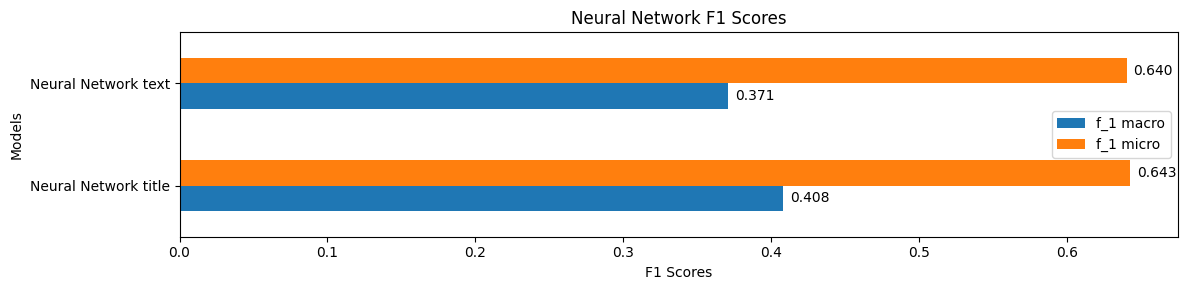

In [40]:
# Create the plot
plt.figure(figsize=(12, 3))
ax = nn_avg_scores[['f_1 macro','f_1 micro']].plot.barh(ax=plt.gca())

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=5)

plt.title('Neural Network F1 Scores')
plt.xlabel('F1 Scores')
plt.ylabel('Models')
plt.tight_layout()
plt.show()

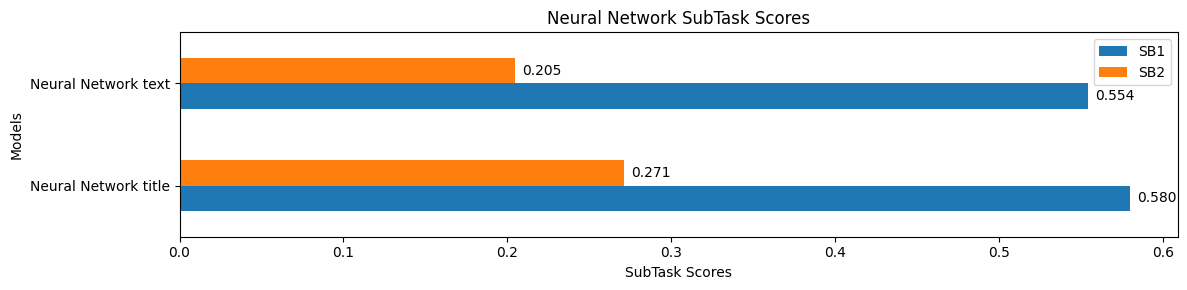

In [41]:
# Create the plot
plt.figure(figsize=(12, 3))
ax = nn_avg_scores[['SB1','SB2']].plot.barh(ax=plt.gca())

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=5)

plt.title('Neural Network SubTask Scores')
plt.xlabel('SubTask Scores')
plt.ylabel('Models')
plt.tight_layout()
plt.show()

## Conclusion


<img src="Images/NN%20vs%20SVM%20f1%20scores.JPG" alt="NN vs SVM F1 Scores" width="900" style="display:inline-block;">
<img src="Images/NN%20vs%20SVM%20subtask%20scores.JPG" alt="NN vs SVM ST" width="900" style="display:inline-block; margin-right:15px;">

